# More Approximate Inference

We have previously introduce the *discrete sampling* method and shown how it can be adapted for conditional distributions using *rejection sampling*, in which we sample from across the parameters space and then only retain those samples which have the correct values of the *evidence variables*: variables that are considered to be fixed by our accumulated knowledge. For example, if we wished to evaluate the distribution $P(M\vert P=True, G=False)$ we would allow the sampler to generate events with $P$ both True and False, and then reject all those samples where $P$ is False.

## Likelihood weighting

An alternative approach is to only generate samples that are consistent with the evidence, that is, that have the same value as the evidence variables. This means that no events are wasted which is good. However, events should not necessarily be treated as 

* Fix all the evidence variables to their observed values
* Sample non-evidence variables conditioned on the fixed evidence variables
* Compute the probability that the sample you have just drawn would give rise to the evidence that you have fixed.
* Include your sample in the trace, weighted by this probability.

Considering our example:
* Fix $P=True$.
* Set weight $w=1.0$.
* $G$ is an evidence variable and is fixed at False. Set $w\leftarrow w\times P(G=False) = 0.4$.
* $M$ is not evidence. Sample from $P(M) = (0.25,0.75)$, suppose this returns True.
* Sample from $P(F\vert M=True) = (0.4,0.6)$, suppose this returns False.
* $P$ is an evidence variable and is True. Set $w\leftarrow w\times P(P=True\vert M=True) = 0.4\times 0.55 = 0.22$.
* Record (False, True, False, True) with weight 0.22.

Why does this work? Firstly, all of the samples generate have the observed values of the evidence variables and so all of the samples can be used. This give improved accuracy results or faster convergens for a given level of accuracy. Secondly, it can be shown rigourously that weighting of the likelihoods in this way is fully consistent with direct sampling from the desired posterior distribution. A proof can be found in Section 14.5.1 of Russell and Norvig (Fifth Edition).


## The Gibbs Sampler

Discrete sampling and its variants all generate samples independently. A new sample in the trace has no knowledge of any previous samples that have been generated. A very common alternative treats the sampling as a *Markov Chain* in which the generation of the next sample depends on the current sample, but not on events prior to the current sample. Markov Chain Monte Carlo (MCMC) sampling methods generate each successive sample by randomly modifying the current sample. There are many different MCMC methods but one that is well-suited for Bayesian networks is the **Gibbs Sampler** named after the Statistical Physicist Josiah Willard Gibbs, whose work in statistical thermodynamics has some close parallels with (and significantly predates) this approach to random sampling.

Gibbs sampling is conceptually very simple.

* Begin by fixing all *evidence variables* to their observed values. These will not be changed through the sampling process.
* Initialise all of the non-evidence variables to random values. These initial values must be supported by the distribution attached to the variable but there are no other requirement of this initialisation.
* A new state is created by sampling *one* of the non-evidence variables, chosen at random. The sampling of the chosen variable will be from its conditional probability distribution which is implicitly or explicitly conditioned on its *Markov Blanket* which is the set of variables that are either parents or children of the chosen variable, or are co-parents of the variable's children. It can be proven that any variable is conditionally independent of all variables outside of its Markov blanket and so we only need to know the local neighbourhood. For small systems, this concept seems rather unecessary, but for Bayesian networks with large number of variables this notion helps to improve the efficiency of the computation.
* The Gibbs sampler determines its outcome by counting how many times it visits each state and normalising. If it visits a state where $M$ is True forty-five times, and $M$ is False fifteen times, the resulting distribution is $P(M\vert F,P)=(0.25,0.75)$. 

The Gibbs sampler is a classical Markov Chain and can be analysed in terms of dynamical systems theory. We will not go in to this in detail here, but we will state the main finding of the analysis: the sampling process settles into an equilibrium in which the the long-run fraction of time that the sampler spends in each state is exactly proportional to that state's posterior probability. This results from the transition probabilities between states being defined by the Markov blankets of the non-evidence variables.

An important aspect of working with the Gibbs samples is that it needs to settle down to that equilibrium state to yield accurate results. In the early stages of the sampling, the samples are not necessarily drawn in proportion to their posterior probability because the initially random state is not yet fully consistent with the sampling distribution. It is therefore very common for Gibbs samplers to require a *burn-in* period to ensure they have reached equilibrium before we start counting states.

We do not typically implement Gibbs samplers from first principles as they are quite tricky to implement and can be sensitive to numerical precision issues. Fortunately the library `pymc3` provides us with a tried-and-trusted implementation that we can just use. Let's build a network in PYMC3.


In [1]:
import pymc as mc
import numpy as np

ModuleNotFoundError: No module named 'pymc'

In [ ]:
with mc.Model() as model:
    Geography = mc.Bernoulli('Geography',0.4)
    Math = mc.Bernoulli('Math',0.75)
    P_Finance = mc.Deterministic('P_Finance', mc.math.switch(Math,0.6,0.2))
    print(P_Finance)
    Finance = mc.Bernoulli('Finance',P_Finance)
    P_Programming = mc.Deterministic('P_Programming', mc.math.switch(Math,0.55,0.45))
    Programming = mc.Bernoulli('Programming',P_Programming)
    step = mc.Metropolis()
    trace = mc.sample(10000, step=step, tune=5000, random_seed=123, progressbar=True)  # init=start,



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Geography]
>Metropolis: [Math]
>Metropolis: [Finance]
>Metropolis: [Programming]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 4 seconds.


array([[<Axes: title={'center': 'Geography'}>,
        <Axes: title={'center': 'Geography'}>],
       [<Axes: title={'center': 'Math'}>,
        <Axes: title={'center': 'Math'}>],
       [<Axes: title={'center': 'Finance'}>,
        <Axes: title={'center': 'Finance'}>],
       [<Axes: title={'center': 'Programming'}>,
        <Axes: title={'center': 'Programming'}>],
       [<Axes: title={'center': 'P_Finance'}>,
        <Axes: title={'center': 'P_Finance'}>],
       [<Axes: title={'center': 'P_Programming'}>,
        <Axes: title={'center': 'P_Programming'}>]], dtype=object)

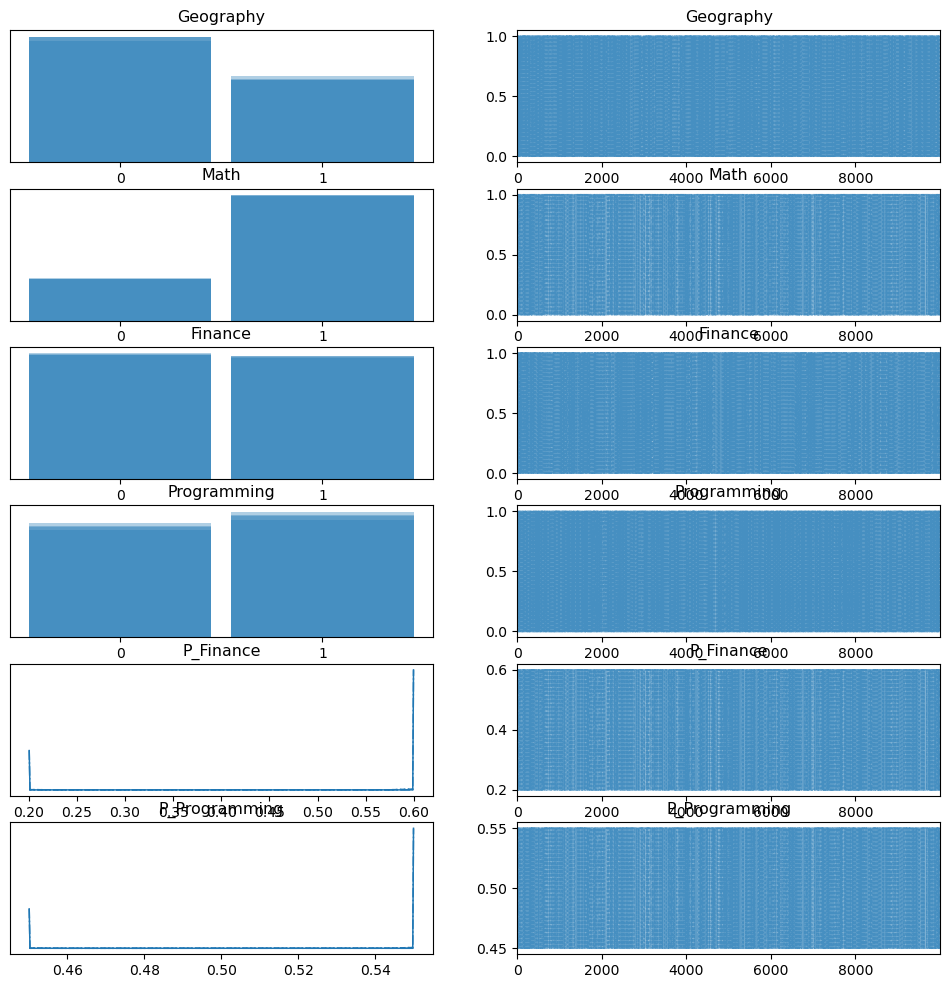

In [3]:
mc.plot_trace(trace)

In [4]:
for t in trace.posterior:
  print(t)

Geography
Math
Finance
Programming
P_Finance
P_Programming


In [5]:
df=trace.to_dataframe(groups='posterior')
print(df)

       chain  draw  Geography  Math  Finance  Programming  P_Finance  \
0          0     0          0     1        1            1        0.6   
1          0     1          0     1        1            1        0.6   
2          0     2          0     1        1            1        0.6   
3          0     3          0     1        1            1        0.6   
4          0     4          0     1        1            1        0.6   
...      ...   ...        ...   ...      ...          ...        ...   
39995      3  9995          0     0        1            0        0.2   
39996      3  9996          0     0        1            0        0.2   
39997      3  9997          0     0        1            0        0.2   
39998      3  9998          1     0        0            0        0.2   
39999      3  9999          1     0        0            0        0.2   

       P_Programming  
0               0.55  
1               0.55  
2               0.55  
3               0.55  
4               0.55

In [6]:
P_Math_Finance = float(df[(df['Finance'] == 1) & (df['Math'] ==1)].shape[0]) / df[df['Finance'] == 1].shape[0]
print(P_Math_Finance)

0.8980303030303031
